# 4. Choix du modèle et des paramètres

## 1. Choix du modèle

Maintenant que nous avons divisé nos données en ensemble d'entraînement et de test, il est temps de construire un modèle d'apprentissage automatique.

Nous allons l'entraîner (trouver les modèles) sur l'ensemble d'entraînement.

Et nous allons le tester (utiliser les modèles) sur l'ensemble de test.

Nous allons essayer plusieurs modèles d'apprentissage automatique différents pour pouvoir comparer leurs scores :

* Régression logistique
* Classificateur K-Nearest Neighbours (voisins les plus proches)
* Classificateur Random Forest
* Linear SVM
* RBF SVM
* Decision Tree
* Neural Network
* AdaBoost
* PassiveAgressive Classifier
* Perceptron
* RidgeClassifier

Nous allons aussi garder à l'esprit que certains modèles (notamment les linéaire) peuvent ressortir des coefficients.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

main_dataset_prepared = pd.read_excel("./buffer/2-main_dataset_prepared.xlsx")
main_dataset_prepared.drop(columns=main_dataset_prepared.columns[0], axis=1, inplace=True)

In [2]:
X = main_dataset_prepared.drop(columns=["Attrition_No", "Attrition_Yes"], axis=1)
y = main_dataset_prepared["Attrition_Yes"]

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=.2,  random_state=0)

## Choix du modèle

On notes les modèles selon leurs performances et si les coefficients des paramètres d'entrées sont disponibles

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier

dict_models = {
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(kernel="linear",  random_state=0),
    "RBF SVM": SVC(random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Neural Net": MLPClassifier(random_state=0),
    "AdaBoost": AdaBoostClassifier(random_state=0),
    "Logistic Regression": LogisticRegression(random_state=0),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(random_state=0),
    "Perceptron": Perceptron(random_state=0),
    "Ridge Classifier": RidgeClassifier(random_state=0)
}

pertinent_model = {}
pertinent_score= {}

for name, model in dict_models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    pertinent_score[name] = score
    print(f"{name}: {score}  |  ", end='')
    if "coef_" in dir(model) and name != "RBF SVM": # coef is available only on svm linear so the methode is available for the RBF but it thows an error when used
        print("coeff available")
        dict_coef = {}
        for i in range(len(model.coef_[0])):
            dict_coef[model.feature_names_in_[i]] = model.coef_[0][i]
        pertinent_model[name] = dict(sorted(dict_coef.items(),key = lambda kv: kv[1], reverse=True))
    else:
        print("coeff unavailable")
    

Nearest Neighbors: 0.8696145124716553  |  coeff unavailable
Linear SVM: 0.8356009070294784  |  coeff available
RBF SVM: 0.9126984126984127  |  coeff unavailable
Decision Tree: 0.9773242630385488  |  coeff unavailable
Random Forest: 0.9875283446712018  |  coeff unavailable
Neural Net: 0.9897959183673469  |  coeff unavailable
AdaBoost: 0.8571428571428571  |  coeff unavailable
Logistic Regression: 0.8469387755102041  |  coeff available
Passive Aggressive Classifier: 0.7993197278911565  |  coeff available
Perceptron: 0.8231292517006803  |  coeff available
Ridge Classifier: 0.854875283446712  |  coeff available


Modèles avec des coefficients diponibles.

Les coefficients représentent la pertinence des paramètres d'entrée sur le résultat. Ces coefficients nous seronts très utiles si le modèle est exploitable car il nous permettera de savoir quels paramètres sont le plus pertinents et quelles sont opérations qui permetteraient d'améliorer la sortie.

In [22]:
for name in pertinent_model.keys():
    print(f"{name}: {pertinent_score[name]}")

Linear SVM: 0.8356009070294784
Logistic Regression: 0.8469387755102041
Passive Aggressive Classifier: 0.7993197278911565
Perceptron: 0.8231292517006803
Ridge Classifier: 0.854875283446712


Nous allons donc choisir 3 modèles parmis ceux testé précédemment.

Nous avons choisis:

* Logistical Regression (meilleur modèle qui propose des coefficients)
* MLPClassifier (meilleur modèle dans l'ensemble bien que peu performant en terme de puissance de calcul)
* RandomForestClassifier (modèle donnant des résultats proche du MLPClassifier mais bien plus performant en terme de puissance de calcul)

## 2. Choix des paramètres

Après avoir choisis nos modèles pertinents, nous allons chercher quels sont les paramtères les mieux adaptés pour notre cas

In [6]:
from sklearn.model_selection import GridSearchCV

def GridSearch(param_grid_dict, dict_models):
    bel = {}

    for name, param_grid in param_grid_dict.items():
        model = dict_models[name]
        gs = GridSearchCV(model, param_grid)
        gs.fit(X_train, y_train)
        score = gs.score(X_test, y_test)
        bel[name] = (score, gs.best_params_)

    return bel

In [27]:
param_grid_dict = {
    'Logistic Regression': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': np.arange(0.05, 0.3, 0.05)
    },
    'Random Forest': {
        'n_estimators': np.arange(120, 140, 10),
        'max_depth': np.arange(30, 50, 10),
        'min_samples_split': np.arange(2, 3, 1),
        'min_samples_leaf': np.arange(3, 5, 1),
        'class_weight': ['balanced', {0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 3}]
    },
    'Neural Net': {
        'solver': ['lbfgs'],
        'max_iter': np.arange(1000, 2000, 300),
        'alpha': 10.**-np.arange(1, 10, 2),
        'hidden_layer_sizes': np.arange(10, 110, 10),
    }
}

In [28]:
best_estimator_list = GridSearch(param_grid_dict, dict_models)

In [29]:
best_estimator_list

{'Logistic Regression': (0.8503401360544217,
  {'C': 0.15000000000000002, 'penalty': 'l2'}),
 'Random Forest': (0.981859410430839,
  {'class_weight': {0: 1, 1: 5},
   'max_depth': 30,
   'min_samples_leaf': 3,
   'min_samples_split': 2,
   'n_estimators': 130}),
 'Neural Net': (0.9909297052154195,
  {'alpha': 0.1,
   'hidden_layer_sizes': 100,
   'max_iter': 1600,
   'solver': 'lbfgs'})}

Erreur et perte

In [30]:
model_dict = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 5}, max_depth=30, min_samples_leaf= 3, min_samples_split=2, n_estimators=130),
    'Logistic Regression': LogisticRegression(C=0.15, penalty="l2"),
    'Multi Layered Perceptron': MLPClassifier(random_state=42, alpha=0.1, hidden_layer_sizes=100, max_iter=1600, solver='lbfgs')
}

y_pred_dict = {}
for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_pred_dict[name] = model.predict(X_test)


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix

def printinfos(y_pred, y_test):
    print(
        '  Root mean squared error : ',
        mean_squared_error(y_test, y_pred, squared = False)
    )
    print(
        '  Mean absolute error :',
        mean_absolute_error(y_test, y_pred)
    )
    print(
        '  Zero One Loss : ',
        zero_one_loss(y_test, y_pred)
    )

    print("\n", pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns= ['predicted_No', 'predicted_Yes'],
        index=['actual_No', 'actual_Yes']
    ))

for name, y_pred in y_pred_dict.items():
    print(f"\nModel name: {name}")
    printinfos(y_pred, y_test)


Model name: Random Forest
  Root mean squared error :  0.13468700594029476
  Mean absolute error : 0.018140589569160998
  Zero One Loss :  0.01814058956916098

             predicted_No  predicted_Yes
actual_No            737              0
actual_Yes            16            129

Model name: Logistic Regression
  Root mean squared error :  0.3868589716493314
  Mean absolute error : 0.14965986394557823
  Zero One Loss :  0.1496598639455783

             predicted_No  predicted_Yes
actual_No            714             23
actual_Yes           109             36

Model name: Multi Layered Perceptron
  Root mean squared error :  0.10647942749998998
  Mean absolute error : 0.011337868480725623
  Zero One Loss :  0.0113378684807256

             predicted_No  predicted_Yes
actual_No            732              5
actual_Yes             5            140


Matrice de confusion

Random Forest


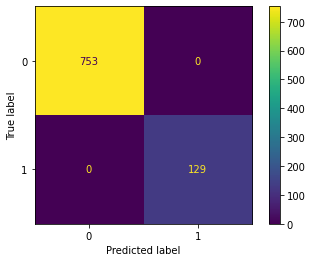

Logistic Regression


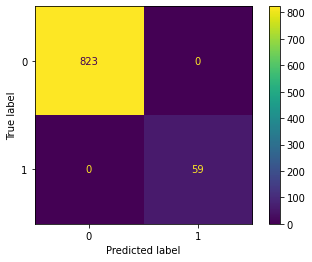

Multi Layered Perceptron


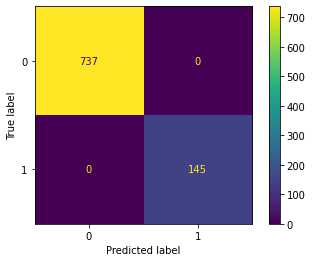

In [32]:
from sklearn import metrics 

for name, model in model_dict.items():
    print(name)
    metrics.plot_confusion_matrix(model, X_test, y_pred_dict[name])  
    plt.show()

In [33]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score, fbeta_score


def printscore(model, y_pred):
    global X_test, y_test
    #Score of our classifier
    print('  Classifier Score :', model.score(X_test, y_test))

    #Precision of our score
    print('  Precision Score :', precision_score(y_test, y_pred))

    # Recall of our score
    print('  Recall Score : ', recall_score(y_test, y_pred))

    # Score of the average precision
    print('  Average Precision Score : ', average_precision_score(y_test, y_pred))

    # F1 Score
    print('  F1 Score : ', f1_score(y_test, y_pred))

    # F Beta Score
    print('  F Beta Score : ', fbeta_score(y_test, y_pred, beta= 0.5))

for name, model in model_dict.items():
    print(f"\nModel name: {name}")
    printscore(model, y_pred_dict[name])


Model name: Random Forest
  Classifier Score : 0.981859410430839
  Precision Score : 1.0
  Recall Score :  0.8896551724137931
  Average Precision Score :  0.9077957619829541
  F1 Score :  0.9416058394160584
  F Beta Score :  0.9757942511346445

Model name: Logistic Regression
  Classifier Score : 0.8503401360544217
  Precision Score : 0.6101694915254238
  Recall Score :  0.2482758620689655
  Average Precision Score :  0.2750731229565662
  F1 Score :  0.35294117647058826
  F Beta Score :  0.47244094488188987

Model name: Multi Layered Perceptron
  Classifier Score : 0.9886621315192744
  Precision Score : 0.9655172413793104
  Recall Score :  0.9655172413793104
  Average Precision Score :  0.9378924776410764
  F1 Score :  0.9655172413793104
  F Beta Score :  0.9655172413793105


Cross validation

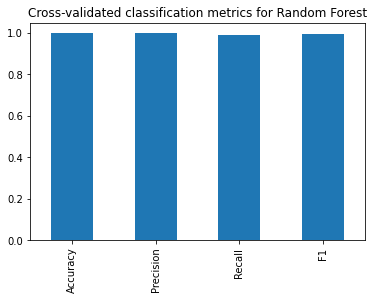

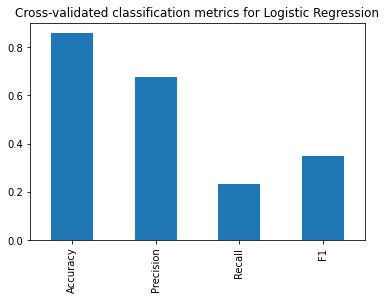

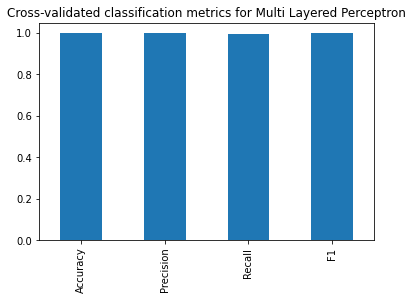

In [34]:
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

for i, modelnname  in enumerate([(k, v) for k, v in model_dict.items()]):
    classifier_acc = cross_val_score(modelnname[1], X, y, cv = 5, scoring="accuracy")
    classifier_precision = cross_val_score(modelnname[1], X, y, cv = 5, scoring="precision")
    classifier_recall = cross_val_score(modelnname[1], X, y, cv = 5, scoring="recall")
    classifier_f1 = cross_val_score(modelnname[1], X, y, cv=5, scoring="f1")

    classifier_acc, classifier_precision, classifier_recall, classifier_f1

    classifierMetrics = pd.DataFrame({
        "Accuracy": np.mean(classifier_acc),
        "Precision": np.mean(classifier_precision),
        "Recall": np.mean(classifier_recall),
        "F1": np.mean(classifier_f1)}, index=[0])

    classifierMetrics.T.plot.bar(
        title=f"Cross-validated classification metrics for {modelnname[0]}",
        legend=False)

Graphes


>- Model Name Random Forest

Precision recall curve


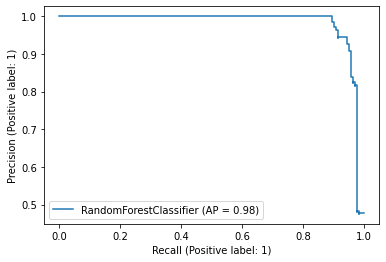

Receiver Operating Characteristic Curve


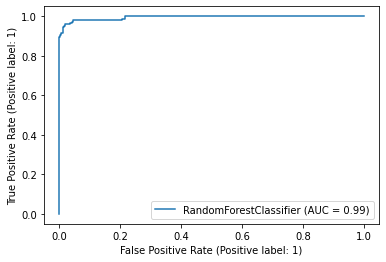

Learning Curve


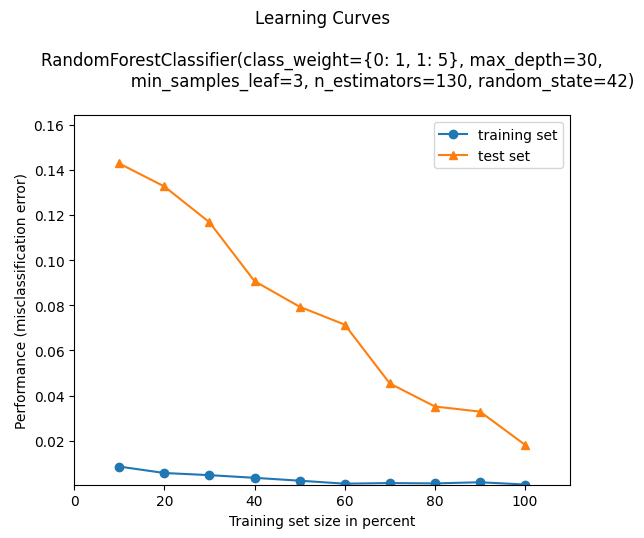


>- Model Name Logistic Regression

Precision recall curve


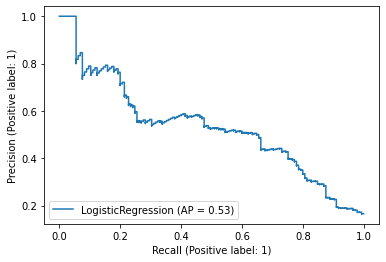

Receiver Operating Characteristic Curve


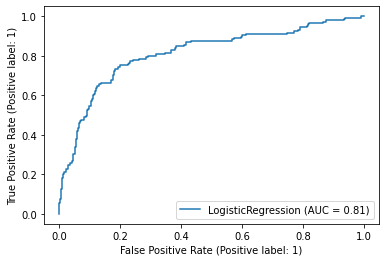

Learning Curve


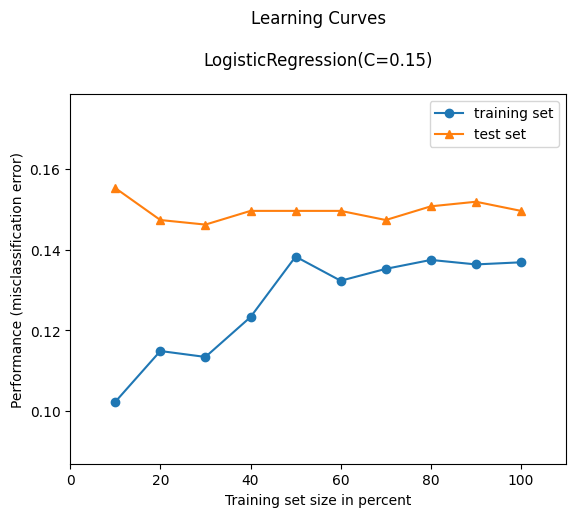


>- Model Name Multi Layered Perceptron

Precision recall curve


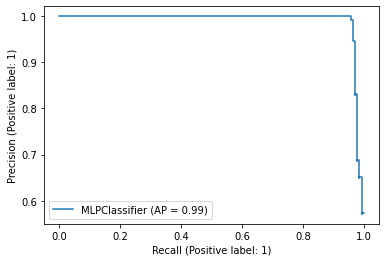

Receiver Operating Characteristic Curve


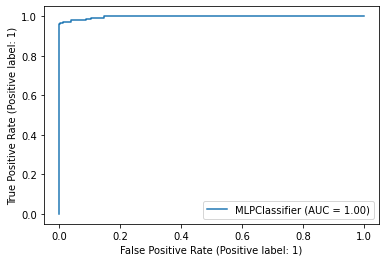

Learning Curve


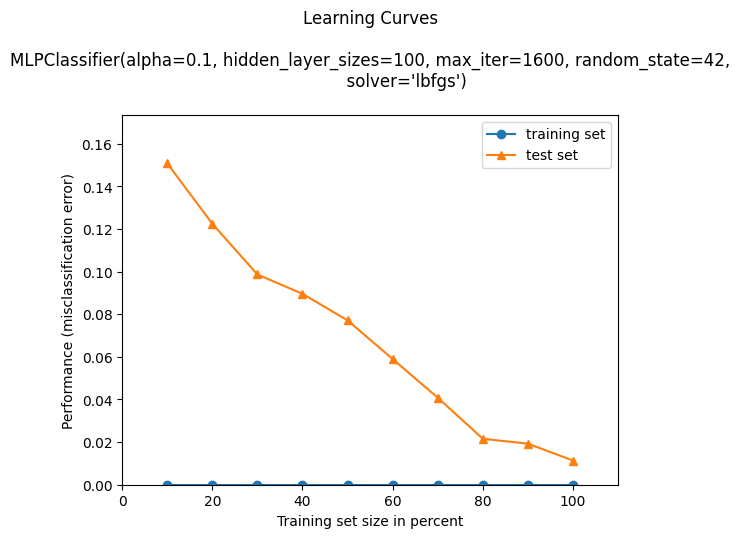

In [35]:
from mlxtend.plotting import plot_learning_curves

for name, model in model_dict.items():

    print(f"\n>- Model Name {name}\n")

    print('Precision recall curve')
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    plt.show()

    print('Receiver Operating Characteristic Curve')
    metrics.plot_roc_curve(model, X_test, y_test)
    plt.show()

    #print('Detection error tradeoff curve')
    #metrics.plot_det_curve(model, X_test, y_test)
    #plt.show()

    print('Learning Curve')
    plot_learning_curves(X_train, y_train, X_test, y_test, model)
    plt.show()


In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_dict["Random Forest"])

0.9448275862068966